## Ganesh Gorti, 5th December 2021

### Regression models (see next notebook for code on Deep Learning)

This code analyses maximum indoor temperature data from 60 households in New Delhi, India. The data was collected between April 2017 and October 2017. The aim of this analysis is to predict the maximum indoor temperatures daily based on a range of features. These include

1. Daily maximum outdoor temperature (in degree celsius)
2. Daily maximum outdoor humidity  
3. Daily maximum outdoor windspeed (in KMPH)
4. Daily maximum heatindex 
5. Daily maximum rainfall. (in mm)
6. Daily maximum solar radiation 
7. Area 
8. Floor of the house 
9. Floor on top (dummy coded as yes or no)
10. Roof Structure (tin sheet, stone slab, concrete, bricks)
11. Wall material (concrete/bricks)
12. Number of ceiling fans 
13. Number of evaporative coolers
14. Flowing ventilation (coded as 0 if no ventilation, 1 if windows are present)
15. Local Climate Zone classification 

Outcome variable -- temp


In [1]:
!pip install geopandas
!pip install contextily

     |████████████████████████████████| 1.0 MB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 15.1 MB/s 
     |████████████████████████████████| 15.4 MB 45.6 MB/s 
     |████████████████████████████████| 19.3 MB 239 kB/s 


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import sklearn

In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection

## Loading Data

In [4]:
import pandas as pd
indoorheat_df=pd.read_csv('https://raw.githubusercontent.com/GaneshGorti/spatialml/main/masterdata.csv')
indoorheat_df.head()

,logger,date,temp,Temp_Out,Out_Hum,Wind_Speed,Heat_Index,Rain,Solar_Rad,Area,Humidity_sensor,Floor,Floor_on_top,Roof_structure,Wall_material,Fan,Evaporative_cooler,Flowing_ventilation,LCZ
0,10692989,12/04/16,31.4,34.3,29,1.8,32.5,0.0,906,Railway Colony,yes,4,no,concrete,bricks,1,yes,1.0,2
1,10692990,12/04/16,31.5,34.3,29,1.8,32.5,0.0,906,Kasturbha Nagar,yes,1,no,concrete,bricks,1,yes,1.0,5
2,10692993,12/04/16,32.7,34.3,29,1.8,32.5,0.0,906,Sarai Kale Khan,yes,3,yes,floor on top,bricks,1,yes,0.0,3
3,10692995,12/04/16,32.9,34.3,29,1.8,32.5,0.0,906,Lodhi Colony,yes,2,no,concrete,bricks,1,yes,1.0,6
4,10692998,12/04/16,32.4,34.3,29,1.8,32.5,0.0,906,Patparganj slum,yes,0,yes,floor on top,bricks,1,yes,1.0,2


In [5]:
indoorheat_df.shape

(10304, 19)

### Checking for Missing Values

In [6]:
indoorheat_df.isnull().sum()

logger                    0
date                      0
temp                   2265
Temp_Out                  0
Out_Hum                   0
Wind_Speed                0
Heat_Index                0
Rain                      0
Solar_Rad                 0
Area                      0
Humidity_sensor           0
Floor                     0
Floor_on_top              0
Roof_structure            0
Wall_material             0
Fan                       0
Evaporative_cooler        0
Flowing_ventilation       0
LCZ                       0
dtype: int64

The dataset has a bunch of NAs on the outcome variable, so in the next step we will drop these. There are not NAs on the predictor variables! 

In [7]:
indoorcleaned_df = indoorheat_df.dropna()

In [8]:
# checking to make sure NAs have been deleted
indoorcleaned_df.isnull().sum()

logger                 0
date                   0
temp                   0
Temp_Out               0
Out_Hum                0
Wind_Speed             0
Heat_Index             0
Rain                   0
Solar_Rad              0
Area                   0
Humidity_sensor        0
Floor                  0
Floor_on_top           0
Roof_structure         0
Wall_material          0
Fan                    0
Evaporative_cooler     0
Flowing_ventilation    0
LCZ                    0
dtype: int64

## Exploring the data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Temp Distribution Plot')

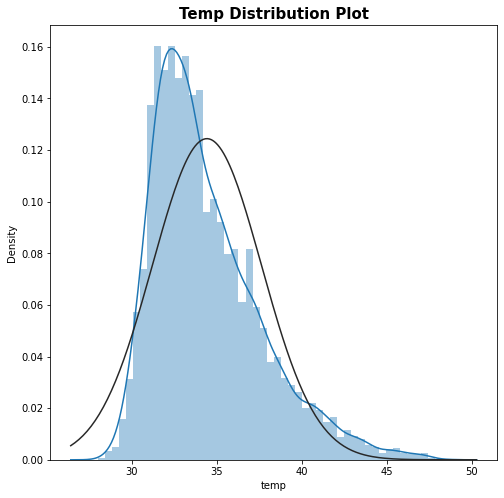

In [9]:
from scipy.stats import norm
plt.figure(figsize=(8,8))
sns.distplot(indoorcleaned_df['temp'], fit=norm)
plt.title("Temp Distribution Plot",size=15, weight='bold')

In [10]:
indoorcleaned_df['temp_log'] = np.log(indoorcleaned_df.temp)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Temp Distribution Plot')

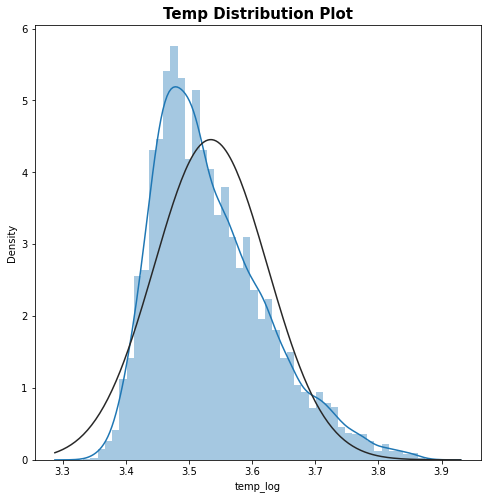

In [11]:
plt.figure(figsize=(8,8))
sns.distplot(indoorcleaned_df['temp_log'], fit=norm)
plt.title("Temp Distribution Plot",size=15, weight='bold')

In [12]:
indoorcleaned_df.head()

,logger,date,temp,Temp_Out,Out_Hum,Wind_Speed,Heat_Index,Rain,Solar_Rad,Area,Humidity_sensor,Floor,Floor_on_top,Roof_structure,Wall_material,Fan,Evaporative_cooler,Flowing_ventilation,LCZ,temp_log
0,10692989,12/04/16,31.4,34.3,29,1.8,32.5,0.0,906,Railway Colony,yes,4,no,concrete,bricks,1,yes,1.0,2,3.446808
1,10692990,12/04/16,31.5,34.3,29,1.8,32.5,0.0,906,Kasturbha Nagar,yes,1,no,concrete,bricks,1,yes,1.0,5,3.449988
2,10692993,12/04/16,32.7,34.3,29,1.8,32.5,0.0,906,Sarai Kale Khan,yes,3,yes,floor on top,bricks,1,yes,0.0,3,3.487375
3,10692995,12/04/16,32.9,34.3,29,1.8,32.5,0.0,906,Lodhi Colony,yes,2,no,concrete,bricks,1,yes,1.0,6,3.493473
4,10692998,12/04/16,32.4,34.3,29,1.8,32.5,0.0,906,Patparganj slum,yes,0,yes,floor on top,bricks,1,yes,1.0,2,3.478158


Transforming categorical variables into numerics.

In [13]:
#len(indoorcleaned_df['Evaporative.cooler'].unique())

In [14]:
#len(indoorcleaned_df['Wall.material'].unique())

In [15]:
#len(indoorcleaned_df['Roof.structure'].unique())

In [16]:
#len(indoorcleaned_df['Humidity.sensor'].unique())

In [17]:
indoorcleaned_df['Evaporative_cooler'] = pd.factorize(indoorcleaned_df.Evaporative_cooler)[0]
indoorcleaned_df['Roof_structure'] = pd.factorize(indoorcleaned_df.Roof_structure)[0]
indoorcleaned_df['Wall_material'] = pd.factorize(indoorcleaned_df.Wall_material)[0]
indoorcleaned_df['Humidity_sensor'] = pd.factorize(indoorcleaned_df.Humidity_sensor)[0]
indoorcleaned_df['Floor_on_top'] = pd.factorize(indoorcleaned_df.Floor_on_top)[0]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [18]:
#indoorcleaned_df = pd.get_dummies(indoorcleaned_df)
indoorcleaned_df.head()

,logger,date,temp,Temp_Out,Out_Hum,Wind_Speed,Heat_Index,Rain,Solar_Rad,Area,Humidity_sensor,Floor,Floor_on_top,Roof_structure,Wall_material,Fan,Evaporative_cooler,Flowing_ventilation,LCZ,temp_log
0,10692989,12/04/16,31.4,34.3,29,1.8,32.5,0.0,906,Railway Colony,0,4,0,0,0,1,0,1.0,2,3.446808
1,10692990,12/04/16,31.5,34.3,29,1.8,32.5,0.0,906,Kasturbha Nagar,0,1,0,0,0,1,0,1.0,5,3.449988
2,10692993,12/04/16,32.7,34.3,29,1.8,32.5,0.0,906,Sarai Kale Khan,0,3,1,1,0,1,0,0.0,3,3.487375
3,10692995,12/04/16,32.9,34.3,29,1.8,32.5,0.0,906,Lodhi Colony,0,2,0,0,0,1,0,1.0,6,3.493473
4,10692998,12/04/16,32.4,34.3,29,1.8,32.5,0.0,906,Patparganj slum,0,0,1,1,0,1,0,1.0,2,3.478158


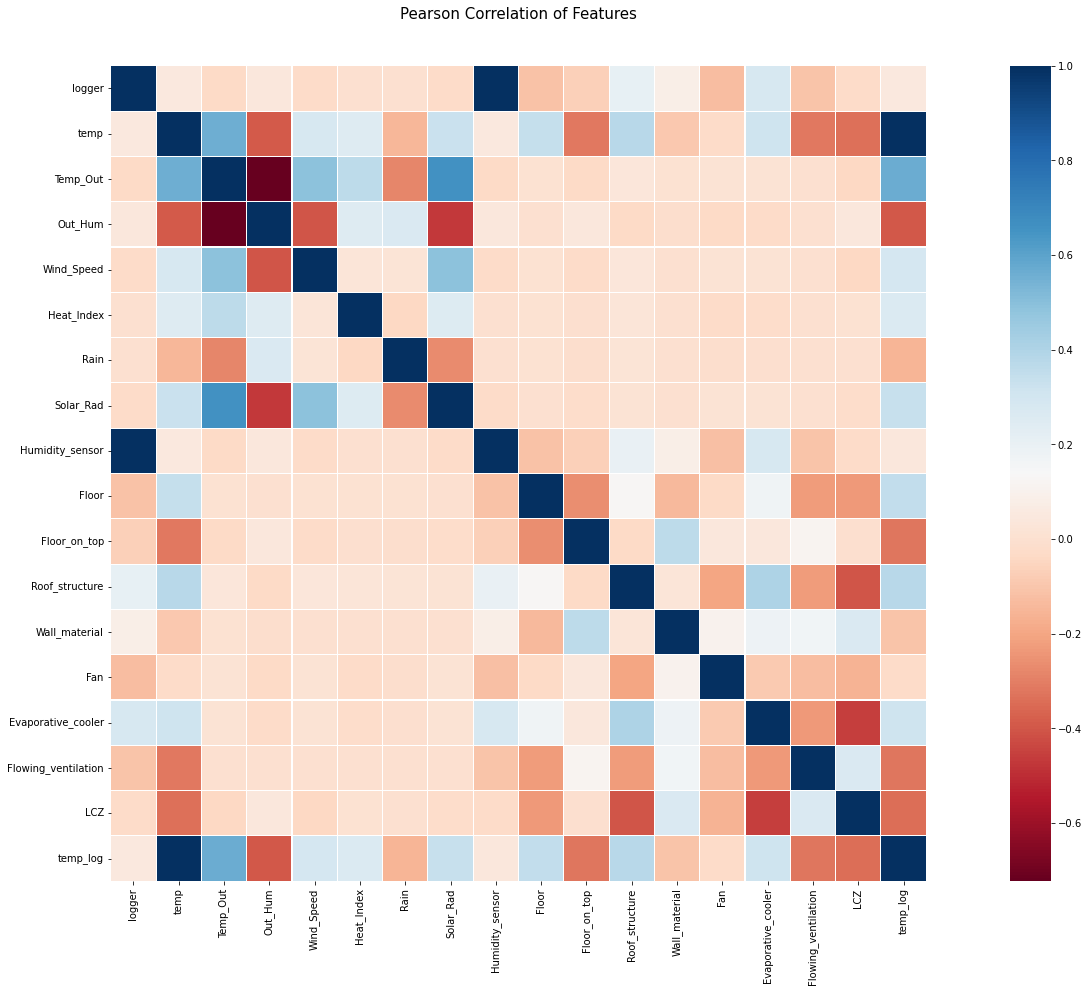

In [19]:
# Plotting the pearson correlation matrix of the features
colormap = plt.cm.RdBu
plt.figure(figsize=(30,15))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(indoorcleaned_df.corr(),linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=False)
plt.show()

We have a few strong correlations, especially with humidity, LCZ, and the presence of ventilation. Linear models might work, but lets see. 

Seperating the features and the target:

In [20]:
indoorcleaned_df = pd.get_dummies(indoorcleaned_df)

indoorcleaned_df.to_csv('indoorheat_df_mod.csv')

In [21]:
X = indoorcleaned_df.drop(['temp', 'temp_log'], axis=1)
Y = indoorcleaned_df['temp']

In [22]:
X.head()

,logger,Temp_Out,Out_Hum,Wind_Speed,Heat_Index,Rain,Solar_Rad,Humidity_sensor,Floor,Floor_on_top,Roof_structure,Wall_material,Fan,Evaporative_cooler,Flowing_ventilation,LCZ,date_01/05/16,date_01/06/16,date_01/07/16,date_01/08/16,date_01/09/16,date_01/10/16,date_02/05/16,date_02/06/16,date_02/07/16,date_02/08/16,date_02/09/16,date_02/10/16,date_03/05/16,date_03/06/16,date_03/07/16,date_03/08/16,date_03/09/16,date_03/10/16,date_04/05/16,date_04/06/16,date_04/07/16,date_04/08/16,date_04/09/16,date_04/10/16,...,date_25/07/16,date_25/08/16,date_25/09/16,date_26/04/16,date_26/05/16,date_26/06/16,date_26/07/16,date_26/08/16,date_26/09/16,date_27/04/16,date_27/05/16,date_27/06/16,date_27/07/16,date_27/08/16,date_27/09/16,date_28/04/16,date_28/05/16,date_28/06/16,date_28/07/16,date_28/08/16,date_28/09/16,date_29/04/16,date_29/05/16,date_29/06/16,date_29/07/16,date_29/08/16,date_29/09/16,date_30/04/16,date_30/05/16,date_30/06/16,date_30/08/16,date_30/09/16,date_31/05/16,date_31/08/16,Area_Kasturbha Nagar,Area_Laxmi Nagar,Area_Lodhi Colony,Area_Patparganj slum,Area_Railway Colony,Area_Sarai Kale Khan
0,10692989,34.3,29,1.8,32.5,0.0,906,0,4,0,0,0,1,0,1.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10692990,34.3,29,1.8,32.5,0.0,906,0,1,0,0,0,1,0,1.0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,10692993,34.3,29,1.8,32.5,0.0,906,0,3,1,1,0,1,0,0.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,10692995,34.3,29,1.8,32.5,0.0,906,0,2,0,0,0,1,0,1.0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,10692998,34.3,29,1.8,32.5,0.0,906,0,0,1,1,0,1,0,1.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [24]:
# Scaling the features using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [25]:
np.isinf(X_train_std).sum()

0

In [26]:
X_train = X_train_std
X_test = X_test_std

## Regression Models





### Linear Model

Linear model without regularization

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
#Instantiate the model:
linear_model= LinearRegression()
#train the model using training data
linear_model.fit(X_train, y_train)

LinearRegression()

In [28]:
train_r2 = round(linear_model.score(X_train, y_train),2)
print('Training R2 score is {}'.format(train_r2))

Training R2 score is 0.73


In [29]:
#RMSE calculations, moving away from R2 from above
y_train_predicted = linear_model.predict(X_train)
#mean_square_error to RMSE
rmse_train_linear = (np.sqrt(mean_squared_error(y_train, y_train_predicted)))
print('RMSE of the linear model for the training set is {}'.format(rmse_train_linear))

RMSE of the linear model for the training set is 1.6614702482401045


In [30]:
y_pred = linear_model.predict(X_test)

rmse_test_linear = (np.sqrt(mean_squared_error(y_test, y_pred)))
print("RMSE of the linear model for the test set is {}".format(rmse_test_linear))

RMSE of the linear model for the test set is 1.7392020665473307


In [31]:
import numpy
numpy.exp(0.52) - 1 

0.6820276496988864

In [32]:
linear_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'feature'}),pd.DataFrame(np.transpose(linear_model.coef_), columns={'coefficient'})], axis = 1) 
linear_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
#Let's just check out the top 5 coefs
linear_coefficients.head()

,feature,coefficient
5,Rain,6.165481e+12
205,Area_Sarai Kale Khan,4.154221e+12
204,Area_Railway Colony,3.785943e+12
201,Area_Laxmi Nagar,3.779180e+12
200,Area_Kasturbha Nagar,3.766508e+12


### Lasso Model


In [33]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV

lasso = Lasso()
lasso_params_grid = {'alpha':np.arange(0.001, 10, 0.05)}

lasso_cv =  RandomizedSearchCV(Lasso(), lasso_params_grid, cv=5, scoring ='neg_root_mean_squared_error', random_state=42)
lasso_cv.fit(X_train,y_train)
lasso_cv.best_params_

{'alpha': 0.751}

In [34]:
best_lasso = Lasso(alpha= 4.751)
best_lasso.fit(X_train, y_train)

Lasso(alpha=4.751)

In [35]:
# model evaluation for training set
train_r2_lasso = round(best_lasso.score(X_train, y_train),2)
print('Training R2 score is {}'.format(train_r2_lasso))
y_train_predicted_lasso = best_lasso.predict(X_train)
rmse_train_lasso = (np.sqrt(mean_squared_error(y_train, y_train_predicted_lasso)))
print('RMSE on the training set for the lasso model is: {}'.format(rmse_train_lasso))

Training R2 score is 0.0
RMSE on the training set for the lasso model is: 3.194942771101432


In [36]:
# model evaluation for test set
y_test_predicted_lasso = best_lasso.predict(X_test)
rmse_test_lasso = (np.sqrt(mean_squared_error(y_test, y_test_predicted_lasso)))
print("RMSE on test set is for the lasso model is: {}".format(rmse_test_lasso))

RMSE on test set is for the lasso model is: 3.233518922429945


In [37]:
lasso_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'feature'}),pd.DataFrame(np.transpose(best_lasso.coef_), columns={'coefficient'})], axis = 1) 
lasso_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
lasso_coefficients.head()

,feature,coefficient
0,logger,0.0
141,date_21/06/16,-0.0
131,date_19/08/16,-0.0
132,date_19/09/16,-0.0
133,date_20/04/16,0.0



Most coefficients are zero, so maybe a linear model is not the best

### Ridge Model


In [38]:
from sklearn.linear_model import Ridge
ridge_params_grid = {'alpha':np.arange(0.001, 10, 0.05)} 
ridge_cv = RandomizedSearchCV(Ridge(), ridge_params_grid, cv=5, scoring ='neg_root_mean_squared_error', random_state=42)
ridge_cv.fit(X_train,y_train)
ridge_cv.best_params_

{'alpha': 0.751}

In [39]:
best_ridge = Ridge(alpha= 8.701)
best_ridge.fit(X_train,y_train)

Ridge(alpha=8.701)

In [40]:
# model evaluation for training set
train_r2_ridge = round(best_ridge.score(X_train, y_train),2)
print('Training R2 score is {}'.format(train_r2_ridge))
y_train_predicted_ridge = best_ridge.predict(X_train)
rmse_train_ridge = (np.sqrt(mean_squared_error(y_train, y_train_predicted_ridge)))
print('RMSE on the training set for the ridge model is: {}'.format(rmse_train_ridge))

Training R2 score is 0.73
RMSE on the training set for the ridge model is: 1.6655930005385573


In [41]:
# model evaluation for test set
y_test_predicted_ridge = best_ridge.predict(X_test)
rmse_test_ridge = (np.sqrt(mean_squared_error(y_test, y_test_predicted_ridge)))
print("RMSE on testing set is for the ridge model is: {}".format(rmse_test_ridge))

RMSE on testing set is for the ridge model is: 1.7415182709134056


In [42]:
ridge_coefficients = pd.concat([pd.DataFrame(X.columns, columns={'variable'}),pd.DataFrame(np.transpose(best_ridge.coef_), columns={'coefficient'})], axis = 1) 
ridge_coefficients.sort_values(by='coefficient', ascending=False, inplace=True)
ridge_coefficients.head()

,variable,coefficient
205,Area_Sarai Kale Khan,0.792870
13,Evaporative_cooler,0.631613
1,Temp_Out,0.573878
0,logger,0.319658
4,Heat_Index,0.317773


### Random Forest Regression

In [43]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(random_state=42)

rf_params = {'max_depth':np.arange(1,10,1),
             'min_samples_split':np.arange(2,50,1),
             'min_samples_leaf':np.arange(2,50,1),
             'max_features':['sqrt', 'log2']} # could also add 'criterion':['mse', 'mae'],

rf_regressor_cv = RandomizedSearchCV(rf_regressor, rf_params, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
rf_regressor_cv.fit(X_train, y_train)
rf_regressor_cv.best_params_

{'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_leaf': 8,
 'min_samples_split': 44}

In [44]:
np.random.seed(42)
best_rf_regressor = RandomForestRegressor(max_depth= 9, max_features = 'sqrt', min_samples_leaf= 8, min_samples_split=44)
best_rf_regressor.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, max_features='sqrt', min_samples_leaf=8,
                      min_samples_split=44)

In [45]:
# model evaluation for training set
train_r2_rf = round(best_rf_regressor.score(X_train, y_train),2)
print('Training R2 score of Random Forest is {}'.format(train_r2_rf))
y_train_predicted_rf = best_rf_regressor.predict(X_train)
rmse_train_rf = (np.sqrt(mean_squared_error(y_train, y_train_predicted_rf)))
print('RMSE on the training set for the Random Forest model is: {}'.format(rmse_train_rf))

Training R2 score of Random Forest is 0.69
RMSE on the training set for the Random Forest model is: 1.7725362713201993


In [46]:
# model evaluation for test set
y_test_predicted_rf = best_rf_regressor.predict(X_test)
rmse_test_rf= (np.sqrt(mean_squared_error(y_test, y_test_predicted_rf)))
print("RMSE on testing set is for the Random Forest model is: {}".format(rmse_test_rf))

RMSE on testing set is for the Random Forest model is: 1.846717217160774


In [47]:
rf_importance = pd.concat([pd.DataFrame(X.columns, columns={'feature'}),pd.DataFrame(np.transpose(best_rf_regressor.feature_importances_), columns={'Importance'})], axis = 1) 
rf_importance.sort_values(by='Importance', ascending=False, inplace=True)
rf_importance.head()

,feature,Importance
10,Roof_structure,0.199167
1,Temp_Out,0.128051
15,LCZ,0.074314
2,Out_Hum,0.070013
205,Area_Sarai Kale Khan,0.056879


###  SVM regression

In [48]:
from sklearn.svm import SVR
svr = SVR()

svr_params = { 'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
              'gamma': ['scale', 'auto'],
              'C': np.arange(0.1, 5,0.4)}

svr_cv = RandomizedSearchCV(svr, svr_params, cv=5, scoring='neg_root_mean_squared_error', random_state=42)
svr_cv.fit(X_train, y_train)
svr_cv.best_params_

{'C': 1.3000000000000003, 'gamma': 'auto', 'kernel': 'rbf'}

In [49]:
best_svr = SVR(C= 1.3000000000000003, gamma= 'auto', kernel= 'rbf')
best_svr.fit(X_train, y_train)

SVR(C=1.3000000000000003, gamma='auto')

In [50]:
# model evaluation for training set
train_r2_svr = round(best_svr.score(X_train, y_train),2)
print('Training R2 score of SVM Regressor is {}'.format(train_r2_svr))
y_train_predicted_svr = best_svr.predict(X_train)
rmse_train_svr = (np.sqrt(mean_squared_error(y_train, y_train_predicted_svr)))
print('RMSE on the training set for the SVM Regressor is: {}'.format(rmse_train_svr))

Training R2 score of SVM Regressor is 0.76
RMSE on the training set for the SVM Regressor is: 1.5626746891209586


In [51]:
# model evaluation for test set
y_test_predicted_svr = best_svr.predict(X_test)
rmse_test_svr= (np.sqrt(mean_squared_error(y_test, y_test_predicted_svr)))
print("RMSE on testing set is for the SVM Regressor is: {}".format(rmse_test_svr))

RMSE on testing set is for the SVM Regressor is: 1.712075320935083


###Stochastic Gradient Boosting Regression

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

In [53]:
gb_regressor = GradientBoostingRegressor(random_state=42)
 
gb_params = dict(learning_rate=np.arange(0.05,0.3,0.05), 
                     n_estimators=np.arange(100,1000,100), 
                     subsample = np.arange(0.1,0.9,0.05),
                     max_depth=[int(i) for i in np.arange(1,10,1)],
                     max_features = ['sqrt', 'log2']) 

gb_cv = RandomizedSearchCV(gb_regressor, gb_params, random_state=42, cv=5, scoring='neg_root_mean_squared_error')
gb_optimized = gb_cv.fit(X_train, y_train)
print('best params: ', gb_optimized.best_params_)

best params:  {'subsample': 0.6000000000000002, 'n_estimators': 700, 'max_features': 'sqrt', 'max_depth': 7, 'learning_rate': 0.1}


In [54]:
np.random.seed(42)
best_gbr = GradientBoostingRegressor(subsample= 0.6000000000000002, n_estimators= 700, max_features= 'sqrt', max_depth= 7, learning_rate= 0.1)
best_gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=7, max_features='sqrt', n_estimators=700,
                          subsample=0.6000000000000002)

In [55]:
# model evaluation for training set
train_r2_gbr = round(best_gbr.score(X_train, y_train),2)
print('Training R2 score of Gradient Boosting Regressor is {}'.format(train_r2_gbr))
y_train_predicted_gbr = best_gbr.predict(X_train)
rmse_train_gbr = (np.sqrt(mean_squared_error(y_train, y_train_predicted_gbr)))
print('RMSE on the training set for the Gradient Boosting Regressor is: {}'.format(rmse_train_gbr))

Training R2 score of Gradient Boosting Regressor is 0.98
RMSE on the training set for the Gradient Boosting Regressor is: 0.39586595581517475


In [56]:
# model evaluation for test set
y_test_predicted_gbr = best_gbr.predict(X_test)
rmse_test_gbr= (np.sqrt(mean_squared_error(y_test, y_test_predicted_gbr)))
print("RMSE on testing set is for the Gradient Boosting Regressor is: {}".format(rmse_test_gbr))

RMSE on testing set is for the Gradient Boosting Regressor is: 0.9757885508824238


In [57]:
gbr_importance = pd.concat([pd.DataFrame(X.columns, columns={'variable'}),pd.DataFrame(np.transpose(best_gbr.feature_importances_), columns={'Importance'})], axis = 1) 
gbr_importance.sort_values(by='Importance', ascending=False, inplace=True)
gbr_importance.head()

,variable,Importance
1,Temp_Out,0.165561
10,Roof_structure,0.086936
0,logger,0.081338
15,LCZ,0.077041
8,Floor,0.063708


## Comparing models

In [58]:
#Same order as above, just the names for printing
models = ['Linear','Lasso', 'Ridge', 'Random Forest', 'SVR', 'Gradient Boosting']
#Creating lists of the values that we stored above
training_r2s = [train_r2, train_r2_lasso, train_r2_ridge, train_r2_rf, train_r2_svr, train_r2_gbr]
rmse_trains = [rmse_train_linear, rmse_train_lasso, rmse_train_ridge, rmse_train_rf, rmse_train_svr, rmse_train_gbr]
rmse_tests= [rmse_test_linear, rmse_test_lasso, rmse_test_ridge, rmse_test_rf, rmse_test_svr, rmse_test_gbr]
#Putting them all in a dictionary to create a table
data = {"model": pd.Series(models), 
        "Training R2": pd.Series(training_r2s), 
        "Training RMSE": pd.Series(rmse_trains),
        "Testing RMSE": pd.Series(rmse_tests)}

comparison_df = pd.concat(data, axis = 1) 
comparison_df

,model,Training R2,Training RMSE,Testing RMSE
0,Linear,0.73,1.661470,1.739202
1,Lasso,0.00,3.194943,3.233519
2,Ridge,0.73,1.665593,1.741518
3,Random Forest,0.69,1.772536,1.846717
4,SVR,0.76,1.562675,1.712075
5,Gradient Boosting,0.98,0.395866,0.975789


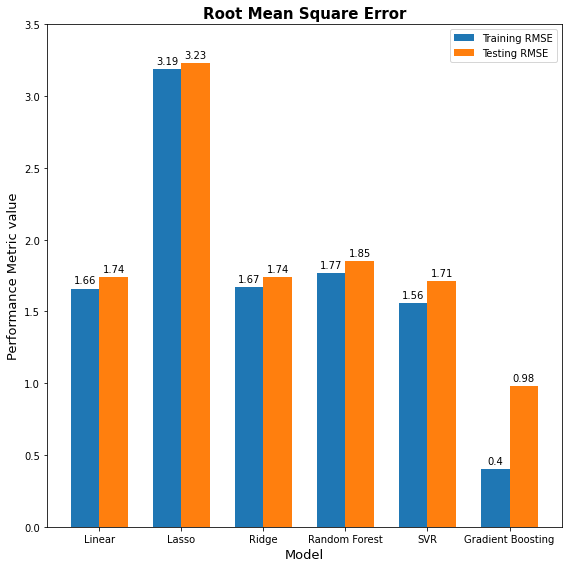

In [59]:
x = np.arange(len(models))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(8,8))
rects1 = ax.bar(x - width/2, round(comparison_df.iloc[:,2],2), width, label='Training RMSE')
rects2 = ax.bar(x + width/2, round(comparison_df.iloc[:,3],2), width, label='Testing RMSE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Performance Metric value',size=13)
ax.set_xlabel('Model',size=13)
ax.set_title("Root Mean Square Error",size=15, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim([0,3.5])
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()